The best way to handle these puzzles is going into part 1 as simple as possible. 
In part 2 we will have to make drastic changes to the code anyways, but part 2 is still unkown.
So any way of being "clever" or trying to write "good" code for part 1 is foolish and 
migh even be contra-productive. As the ancient saysing goes: 

> Pre-mature optimization is the root of all evil



In [1]:
import numpy as np

In [49]:
def read_file(s):
    largest = [0, 0, 0]
    buffer = []

    with open(s) as f:
        for line in f.readlines():
            line = line.strip()
            if line == "":
                continue
            vals = tuple(int(a) for a in line.split(","))
            buffer.append(vals)
            # add some additional space like +3 for axis rolling
            largest = [max(i,j+3) for (i,j) in zip(largest, vals)]

    vol = np.zeros(shape=largest, dtype=np.int_)
    for b in buffer:
        vol[b] = 1

    return vol

In [70]:
m = read_file("example")

In [77]:
diff = np.array(6*m)
for axis in (0, 1, 2):
    for shift in (-1, 1):
        diff -= np.roll(m, shift=shift, axis=axis)

diff[diff < 0] = 0
np.sum(diff)

64

Put it all in one funtion

In [78]:
def part1(s):
    m = read_file(s)
    diff = np.array(6*m)
    for axis in (0, 1, 2):
        for shift in (-1, 1):
            diff -= np.roll(m, shift=shift, axis=axis)

    diff[diff < 0] = 0
    return np.sum(diff)

In [79]:
part1("example")

64

In [80]:
part1("input")

3494

# Part 2

I will calculate that with a heat simulation. (Not the best way, but what the heck?)

At the edge (x=0) we will have a constant temperatur $T(0, y, z)=100$. For each 
cube we have the heating law:

$$
\frac{d}{dt} T = \gamma \nabla^2 T 
$$

but the blocks will not heat: $\frac{d}{dt} T(x_i, y_i, z_i) = 0$ for
$(x_i, y_i, z_i)$ is a lava cube and stay constant $T(x_i, y_i, z_i) = 0$.
We will assume, that gamma is 1 (in the appropriate units).

The reasoning behind this is, that air pockets will not heat.

In [256]:
import matplotlib.pyplot as plt

In [334]:
m = read_file("example")
T_map = np.zeros_like(m, dtype=np.float_)

In [335]:
def time_step(T_map, dt, cube_map):
    T_map[0] = 100
    
    # calculate the laplacian
    # this can be done better with convolve (but I dont have time for this)
    lapl = np.array(6*T_map)
    for axis in (0, 1, 2):
        for shift in (-1, 1):
            lapl -= np.roll(T_map, shift=shift, axis=axis)

    T_map[cube_map != 1]-= dt*lapl[cube_map != 1]
    T_map[0] = 100


It might take some time for heat to percolate into deep holes in the lava. Let's see if the global temperature reaches a steady state...

In [336]:
temps = []
for n in range(10000):
    time_step(T_map, 0.001, m)
    temps.append(np.sum(T_map)/ np.prod(T_map.shape))


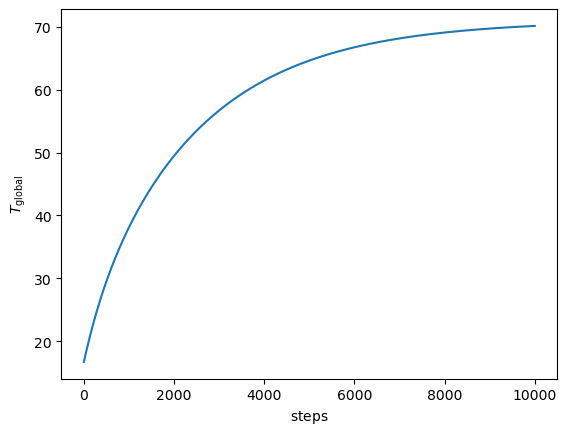

In [337]:
plt.plot(temps)
plt.xlabel("$\\mathrm{steps}$")
plt.ylabel("$T_{\\mathrm{global}}$");

So we seem to have reached a good steady state. Now we can compare the 
sites were we have $T=0$ to the cube sites. The difference should give
us the holes.

For example, take the slice for $y=2$:

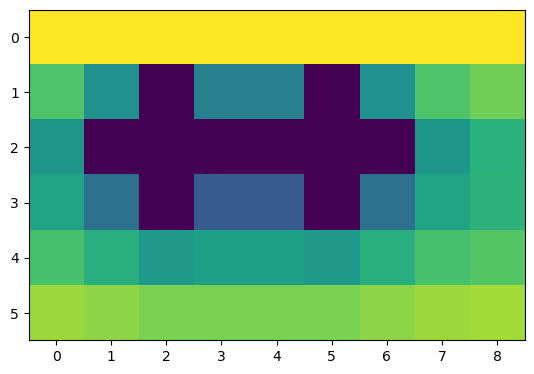

In [338]:
plt.imshow(T_map[:,2], aspect='equal');

Where is the temperatur zero?

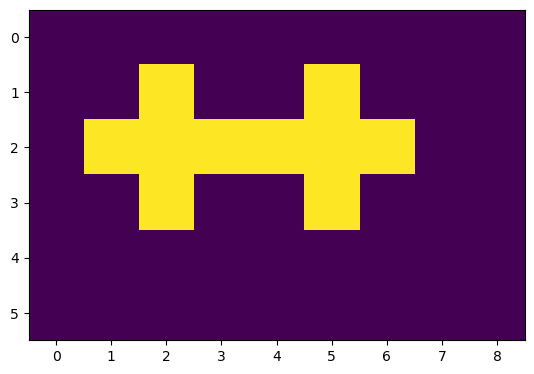

In [339]:
plt.imshow(T_map[2] == 0, aspect='equal')

Compare that to the cube map:

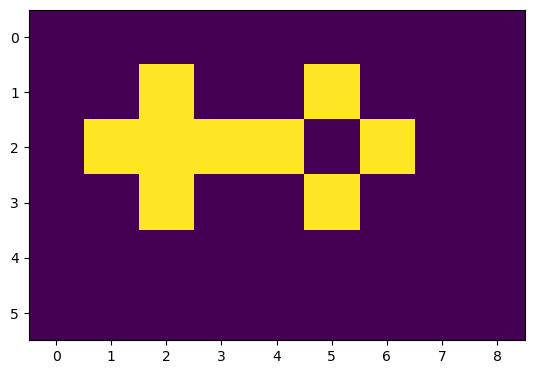

In [340]:
plt.imshow(m[2], aspect='equal')

So we can find the hole at 2,2,5!

All holes:

In [341]:
low_temp = np.zeros_like(T_map)
low_temp[T_map == 0] = 1
np.sum(low_temp - m)

1.0

But we can not simply assume, that a hole takes away 6 units of area. Only if the hole touches a lava cube and then also only how many cubes. To find this out we can employ
the same strategy as in part 1. We just fill in all the holes and calculate the surface area again!

In [355]:
holes = low_temp - m

filled = np.array(m)
filled[holes == 1] = 1

diff = np.array(6*filled)
for axis in (0, 1, 2):
    for shift in (-1, 1):
        diff -= np.roll(filled, shift=shift, axis=axis)

diff[diff < 0] = 0
np.sum(diff)

58

In [358]:
def part2(s, steps=10000):
    m = read_file(s)
    T_map = np.zeros_like(m, dtype=np.float_)
    
    temps = []
    for n in range(steps):
        time_step(T_map, 0.001, m)
        temps.append(np.sum(T_map)/ np.prod(T_map.shape))

    plt.figure(figsize=(6,10))
    plt.subplot(2, 1, 1)
    plt.plot(temps)
    plt.xlabel("$\\mathrm{steps}$")
    plt.ylabel("$T_{\\mathrm{global}}$")

    plt.subplot(2, 1, 2)
    _, w, _ = T_map.shape
    plt.imshow(T_map[:,w//2], aspect='equal');

    low_temp = np.zeros_like(T_map)
    low_temp[T_map == 0] = 1

    holes = low_temp - m

    filled = np.array(m)
    filled[holes == 1] = 1

    diff = np.array(6*filled)
    for axis in (0, 1, 2):
        for shift in (-1, 1):
            diff -= np.roll(filled, shift=shift, axis=axis)

    diff[diff < 0] = 0

    return np.sum(diff)

58

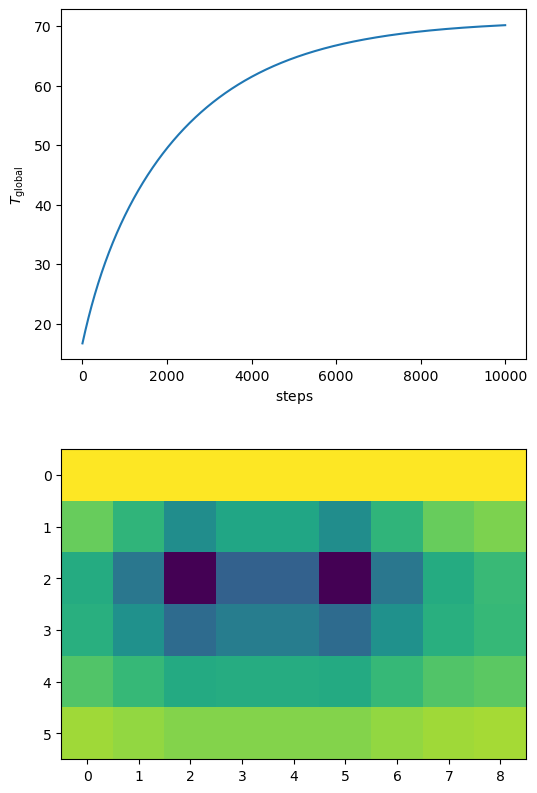

In [359]:
part2("example")

2062

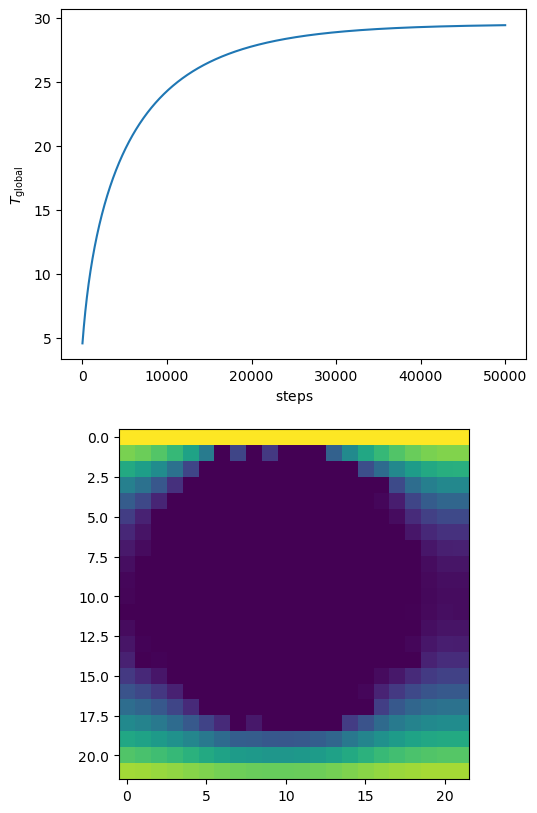

In [363]:
part2("input", steps=50000)